In [1]:
import torch
import cv2
from segment_anything import sam_model_registry, SamPredictor
from segment_anything import SamAutomaticMaskGenerator_mod2 as SamAutomaticMaskGenerator
#from segment_anything import SamAutomaticMaskGenerator as SamAutomaticMaskGenerator
import numpy as np
import matplotlib.pyplot as plt
import glob
import torch
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import functions as fnc
import First_second_fnc as FS_fnc
from importlib import reload
import gc
from skimage.measure import label, regionprops
from collections import Counter
from torchvision.ops.boxes import batched_nms
from sklearn.neighbors import KDTree
import matplotlib.colors as mcolors
import time
from skimage.morphology import binary_dilation
import json
from tqdm import tqdm
import pandas as pd


In [2]:
#load image
#OutDIR='/DATA/vito/output/Ravi2_run2_dw8_cp1024_pps48/'
OutDIR='/DATA/vito/output/Ravi4_run2_dw4_cp512_3b/'
with open(OutDIR+'init_para.json', 'r') as json_file:
    init_para = json.load(json_file)
with open(OutDIR+'pre_para.json', 'r') as json_file:
    pre_para = json.load(json_file)

DataDIR=init_para.get('DataDIR')
DSname=init_para.get('DatasetName')
fid=init_para.get('fid')
resample_factor=init_para.get('resample_factor')

In [3]:
third_b_resmpale=init_para.get('third_b_resample_factor')
crop_size=init_para.get('crop_size')
resample_factor=init_para.get('resample_factor')
dilation_size=init_para.get('dilation_size')
#min_pixel=(init_para.get('expected_min_size(sqmm)')/(init_para.get('resolution(mm)')**2))*resample_factor
#min_radi=init_para.get('min_radius')

In [10]:
image=fnc.load_image(DataDIR,DSname,fid)
print('Image size:', image.shape)
org_shape=image.shape
image=fnc.preprocessing_roulette(image, pre_para)
print('Image size:', image.shape)
print('Preprocessing finished')

ar_masks=np.array(np.load(OutDIR+f'Merged/all_mask_merged_windows_id.npy', allow_pickle=True))
print('Mask size:', ar_masks.shape)
print(len(np.unique(ar_masks)),' mask(s) loaded')

Ravi4_orthomosaic_clip_02mm.tif imported
Image size: (17592, 21739, 3)
Image size: (4398, 5435, 3)
Preprocessing finished
Mask size: (4398, 5435)
5441  mask(s) loaded


In [5]:
#identify void
kernel = np.ones((dilation_size, dilation_size), np.uint8)
stacked_Aggregate_masks_noedge_nms_eroded=binary_dilation(ar_masks>=1, kernel)
no_mask_area=label(stacked_Aggregate_masks_noedge_nms_eroded,1,False,1)
regions=regionprops(no_mask_area)

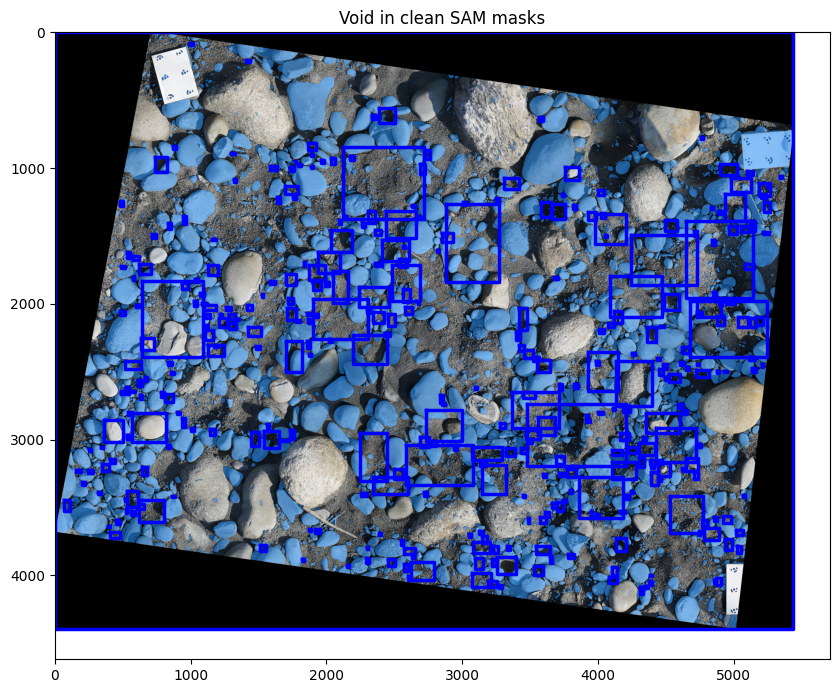

In [6]:
plt.figure(figsize=(10,10))
plt.imshow(image)
fnc.show_mask(ar_masks>0,plt.gca(),np.array([30/255, 144/255, 255/255]))
fxy=[]
for i,region in enumerate(regions):
    # take regions with large enough areas
    if (region.area > 100):
        mask=np.array(no_mask_area==(i+1))
        y0, x0 =region.centroid
        minr, minc, maxr, maxc = region.bbox
        bx = (minc, maxc, maxc, minc, minc)
        by = (minr, minr, maxr, maxr, minr)
        width, length=np.max(bx)-np.min(bx),np.max(by)-np.min(by)

        #plt.plot(x0, y0, '.g', markersize=15)
        plt.plot(bx, by, '-b', linewidth=2.5)
        factor=int((np.max([length/resample_factor,width/resample_factor]))//(crop_size*0.5))+1
        if factor<(np.max(org_shape)*0.8)/(crop_size):
            fxy.append(factor)
plt.title('Void in clean SAM masks')
plt.show()

#auto resampling factor
required_resampling=1/(np.max(fxy))

In [7]:
resampled_SAM=np.load(OutDIR+'Third/all_mask_third_pass_id.npy')
resampled_SAM=cv2.resize(resampled_SAM.astype(np.uint16), ar_masks.shape[::-1], interpolation = cv2.INTER_NEAREST)

#finding mask that is only inside the void
ids_in_void,counts_in_void=np.unique(resampled_SAM[(ar_masks==0).astype('bool')], return_counts=True)
ids_total,counts_total=np.unique(resampled_SAM, return_counts=True)
valid_ids=[]
for id,count in zip(ids_in_void,counts_in_void):
    if count>=((counts_total[ids_total==id])*0.85):#if the object is at least 85% inside the voids
        valid_ids.append(id)

largest_id=np.max(ar_masks)

mask = np.isin(resampled_SAM, valid_ids)
id_mask = np.where(mask, resampled_SAM, 0)


In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(image)
fnc.show_mask(ar_masks>0,plt.gca(),np.array([30/255, 144/255, 255/255]))
fxy=[]
for i,region in enumerate(regions):
    # take regions with large enough areas
    if (region.area > 100):
        mask=np.array(no_mask_area==(i+1))
        y0, x0 =region.centroid
        minr, minc, maxr, maxc = region.bbox
        bx = (minc, maxc, maxc, minc, minc)
        by = (minr, minr, maxr, maxr, minr)
        width, length=np.max(bx)-np.min(bx),np.max(by)-np.min(by)

        #plt.plot(x0, y0, '.g', markersize=15)
        plt.plot(bx, by, '-b', linewidth=2.5)
        factor=int((np.max([length/resample_factor,width/resample_factor]))//(crop_size*0.5))+1
        if factor<(np.max(org_shape)*0.8)/(crop_size):
            fxy.append(factor)
plt.title('Void in clean SAM masks')
plt.show()

#auto resampling factor
required_resampling=1/(np.max(fxy))

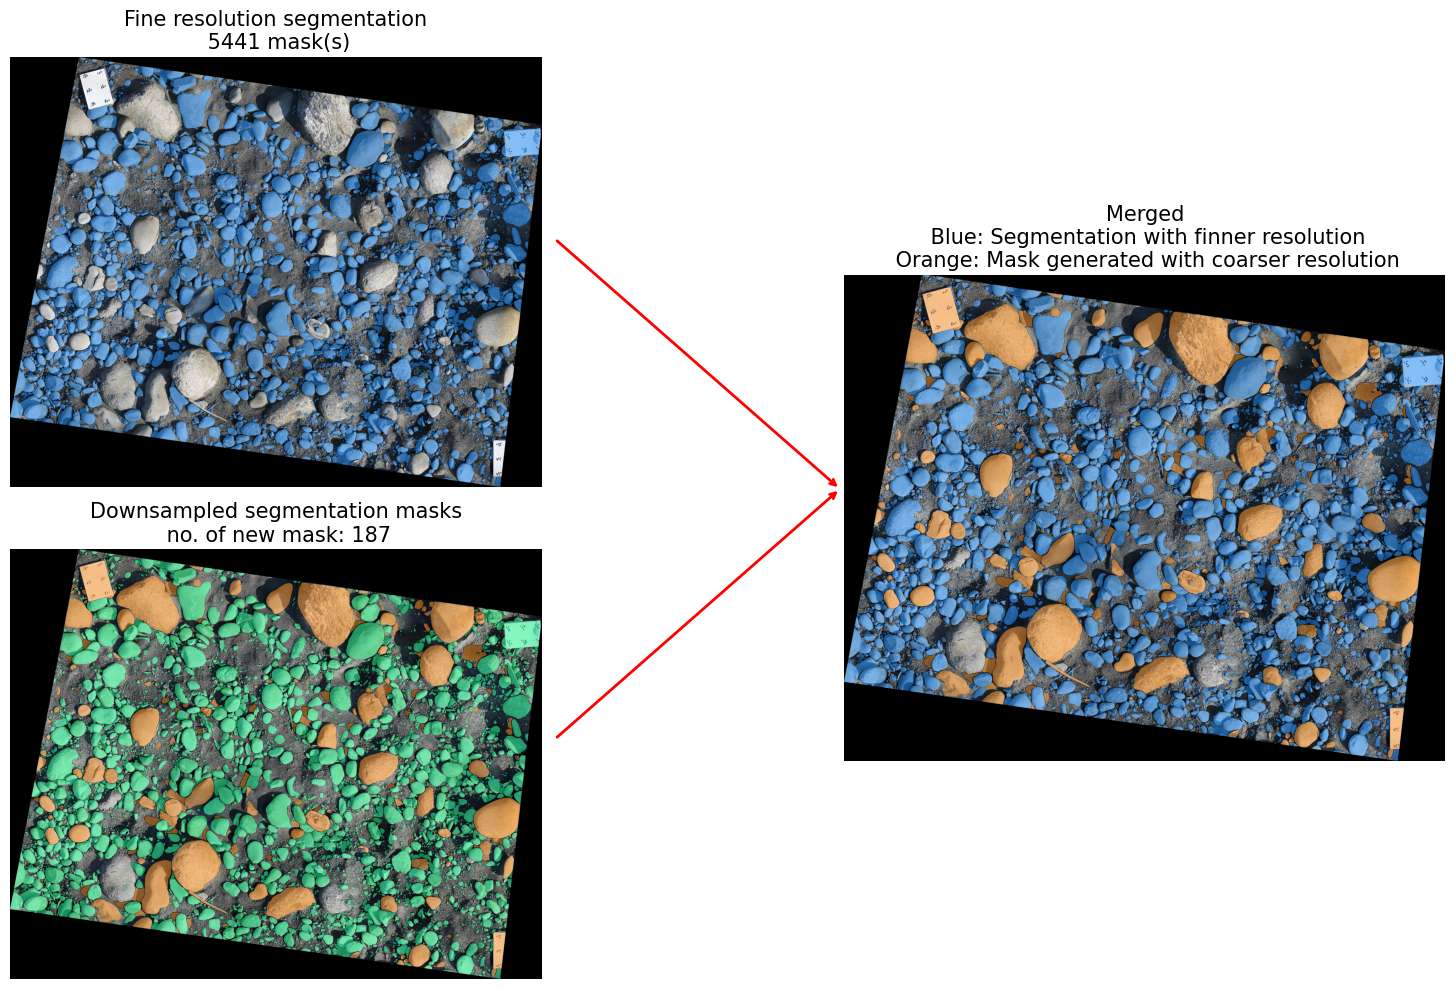

In [32]:
resampled_SAM_discarded=resampled_SAM.copy()
resampled_SAM_discarded[id_mask>0]=0

fig = plt.figure(figsize=(15, 10))

# Subplots
ax1 = fig.add_subplot(2, 2, 1)  # Top-left
ax2 = fig.add_subplot(2, 2, 3)  # Bottom-left
ax3 = fig.add_subplot(1, 2, 2)  # Right image (spanning both rows)

# Display images
ax1.imshow(image)
fnc.show_mask(ar_masks>0,ax1,np.array([30/255, 144/255, 255/255]))
ax1.set_title(f'Fine resolution segmentation\n {len(np.unique(ar_masks))} mask(s)', fontsize=15)
ax2.imshow(image)
fnc.show_mask(resampled_SAM_discarded>0,ax2,np.array([30/255, 255/255, 144/255]))
fnc.show_mask(id_mask>0,ax2,np.array([255/255, 144/255, 30/255]))
ax2.set_title(f'Downsampled segmentation masks\n no. of new mask: {len(valid_ids)}', fontsize=15)
ax3.imshow(image)
fnc.show_mask(ar_masks>0,ax3,np.array([30/255, 144/255, 255/255]))
fnc.show_mask(id_mask>0,ax3,np.array([255/255, 144/255, 30/255]))
ax3.set_title('Merged\n Blue: Segmentation with finner resolution\n Orange: Mask generated with coarser resolution', fontsize=15)

plt.subplots_adjust(wspace=0.3)

for ax in [ax1, ax2, ax3]:
    ax.axis("off")

fig.canvas.draw() 

x_left = 0.37  
x_right = 0.56 
y_top = 0.75  
y_bottom = 0.25  
y=0.5

plt.annotate("", xy=(x_right, y), xytext=(x_left, y_top),
             xycoords="figure fraction", textcoords="figure fraction",
             arrowprops=dict(arrowstyle="->", color="red", lw=2))

plt.annotate("", xy=(x_right, y), xytext=(x_left, y_bottom),
             xycoords="figure fraction", textcoords="figure fraction",
             arrowprops=dict(arrowstyle="->", color="red", lw=2))

plt.tight_layout()
plt.show()